## Hyperparameters optimization for Random Forest in the case of multiclass (Sell, Hold, Buy)

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report




In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [4]:
target

Date
2018-01-02    1
2018-01-03    1
2018-01-04    1
2018-01-05    1
2018-01-08    1
             ..
2022-12-23    1
2022-12-26    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Name: target, Length: 1253, dtype: int64

In [5]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

## Baseline Random Forest Classifier without new data

In [7]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [9]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = [None, 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap, 
               'rf__criterion':criterion,
               }


In [11]:
n_iter = 200
verbose_level = 1
n_jobs = 4

In [12]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [13]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [14]:
rf_random.best_params_

{'rf__n_estimators': 33,
 'rf__min_samples_split': 10,
 'rf__min_samples_leaf': 4,
 'rf__max_features': 'log2',
 'rf__max_depth': 16,
 'rf__criterion': 'gini',
 'rf__bootstrap': False}

In [15]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
59,0.092862,0.004744,0.003613,0.000268,33,10,4,log2,16,gini,False,"{'rf__n_estimators': 33, 'rf__min_samples_spli...",0.651741,0.716418,0.740,0.690,0.745,0.708632,0.034499,1
128,1.053424,0.028784,0.025152,0.005735,192,10,4,log2,18,entropy,False,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.666667,0.721393,0.730,0.705,0.715,0.707612,0.022041,2
197,1.986477,0.097123,0.020399,0.002492,184,5,2,None,None,entropy,True,"{'rf__n_estimators': 184, 'rf__min_samples_spl...",0.641791,0.701493,0.755,0.710,0.725,0.706657,0.037199,3
50,0.068170,0.005999,0.004390,0.000676,17,5,2,log2,16,gini,False,"{'rf__n_estimators': 17, 'rf__min_samples_spli...",0.666667,0.726368,0.735,0.700,0.700,0.705607,0.023976,4
106,0.842013,0.029126,0.024482,0.002672,184,2,2,log2,20,gini,False,"{'rf__n_estimators': 184, 'rf__min_samples_spl...",0.666667,0.711443,0.740,0.700,0.700,0.703622,0.023565,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.229122,0.007536,0.010992,0.002106,105,5,1,sqrt,2,log_loss,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.517413,0.552239,0.550,0.570,0.535,0.544930,0.017683,196
135,0.225501,0.006663,0.010754,0.002218,105,5,1,log2,2,gini,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.532338,0.537313,0.550,0.565,0.535,0.543930,0.012155,197
69,0.458989,0.094618,0.013501,0.004182,152,5,2,None,2,entropy,True,"{'rf__n_estimators': 152, 'rf__min_samples_spl...",0.537313,0.547264,0.550,0.545,0.535,0.542915,0.005788,198
60,0.143034,0.004656,0.006451,0.000521,73,10,1,None,2,gini,True,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.537313,0.557214,0.550,0.520,0.540,0.540905,0.012645,199


In [16]:
best_model = rf_random.best_estimator_

In [17]:
best_model.score(X_test, y_test)

0.6733067729083665

In [18]:
predictions = best_model.predict(X_test)

In [19]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       123
           1       0.71      0.62      0.66       128

    accuracy                           0.67       251
   macro avg       0.68      0.67      0.67       251
weighted avg       0.68      0.67      0.67       251



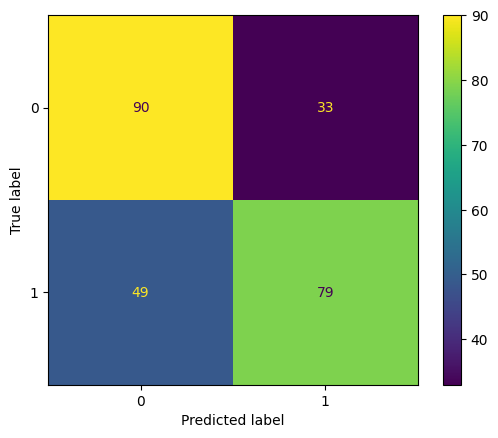

In [20]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

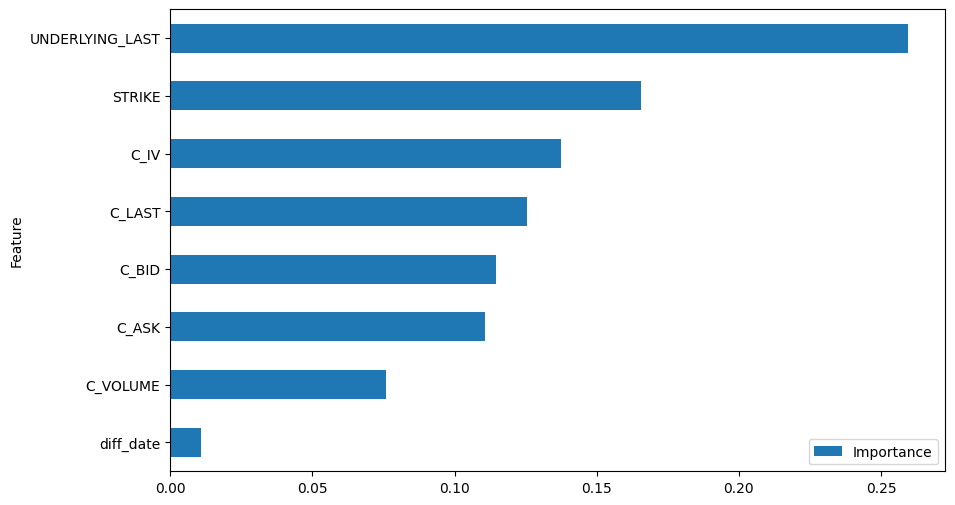

In [21]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': orig_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation

In [22]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [24]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [25]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [26]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [27]:
rf_random.best_params_

{'rf__n_estimators': 65,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'sqrt',
 'rf__max_depth': None,
 'rf__criterion': 'entropy',
 'rf__bootstrap': False}

In [28]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
174,0.805935,0.172249,0.011059,0.001631,65,2,2,sqrt,None,entropy,False,"{'rf__n_estimators': 65, 'rf__min_samples_spli...",0.766169,0.805970,0.760,0.750,0.790,0.774428,0.020545,1
106,1.005570,0.065267,0.026460,0.006731,184,2,2,log2,20,gini,False,"{'rf__n_estimators': 184, 'rf__min_samples_spl...",0.761194,0.781095,0.750,0.765,0.795,0.770458,0.015809,2
33,1.505218,0.069355,0.027477,0.003859,192,5,1,log2,18,log_loss,False,"{'rf__n_estimators': 192, 'rf__min_samples_spl...",0.761194,0.776119,0.760,0.760,0.790,0.769463,0.011946,3
136,0.452419,0.039216,0.011905,0.002785,81,5,1,sqrt,20,gini,False,"{'rf__n_estimators': 81, 'rf__min_samples_spli...",0.751244,0.776119,0.760,0.780,0.775,0.768473,0.010978,4
158,0.993249,0.036329,0.018782,0.002761,128,5,2,log2,18,entropy,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.746269,0.800995,0.750,0.755,0.790,0.768453,0.022525,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.208919,0.015385,0.011335,0.002223,89,2,2,log2,2,gini,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.542289,0.577114,0.565,0.555,0.545,0.556881,0.012907,196
88,0.213190,0.003469,0.009059,0.002118,89,10,1,log2,2,log_loss,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.557214,0.567164,0.555,0.560,0.540,0.555876,0.008933,197
195,0.099221,0.005960,0.006632,0.001708,41,5,1,sqrt,2,gini,False,"{'rf__n_estimators': 41, 'rf__min_samples_spli...",0.537313,0.557214,0.570,0.555,0.550,0.553905,0.010599,198
15,0.307391,0.007419,0.013716,0.002573,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.557214,0.557214,0.555,0.560,0.540,0.553886,0.007122,199


In [29]:
best_model = rf_random.best_estimator_

In [30]:
best_model.score(X_test, y_test)

0.7649402390438247

In [31]:
predictions = best_model.predict(X_test)

In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.78      0.76       123
           1       0.78      0.75      0.76       128

    accuracy                           0.76       251
   macro avg       0.77      0.77      0.76       251
weighted avg       0.77      0.76      0.76       251



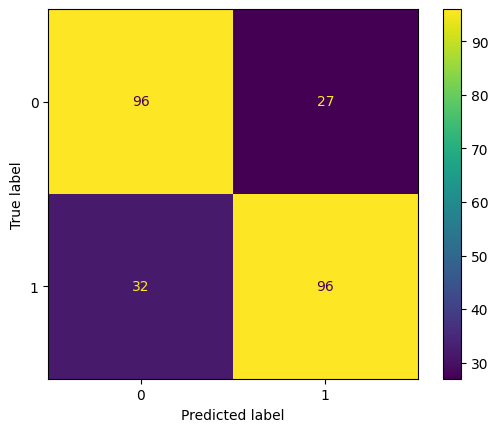

In [33]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

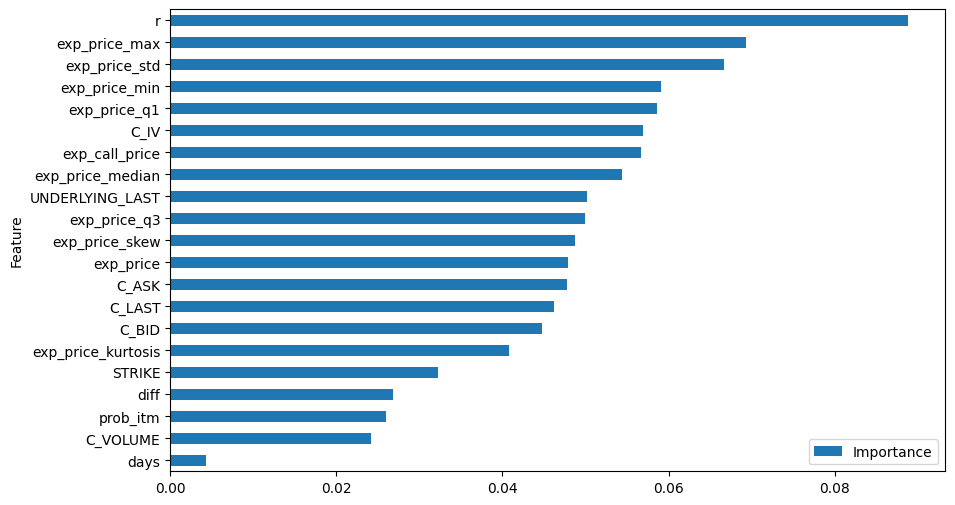

In [34]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Random Forest with data from MC simulation and some addtional features

In [35]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [36]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["STRIKE"]+new_df["C_LAST"])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [38]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [39]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [40]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [41]:
rf_random.best_params_

{'rf__n_estimators': 73,
 'rf__min_samples_split': 5,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'log2',
 'rf__max_depth': 18,
 'rf__criterion': 'gini',
 'rf__bootstrap': False}

In [42]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
58,0.472701,0.024366,0.013480,0.002635,73,5,2,log2,18,gini,False,"{'rf__n_estimators': 73, 'rf__min_samples_spli...",0.786070,0.776119,0.760,0.745,0.790,0.771438,0.016795,1
141,0.748625,0.023563,0.016869,0.004832,105,5,1,sqrt,20,entropy,True,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.776119,0.746269,0.745,0.775,0.800,0.768478,0.020683,2
158,1.005496,0.047816,0.018703,0.001708,128,5,2,log2,18,entropy,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.776119,0.776119,0.745,0.755,0.780,0.766448,0.013869,3
119,0.626848,0.032679,0.009889,0.001220,81,2,2,log2,None,entropy,False,"{'rf__n_estimators': 81, 'rf__min_samples_spli...",0.751244,0.810945,0.745,0.735,0.790,0.766438,0.029034,4
136,0.519413,0.033524,0.013587,0.003747,81,5,1,sqrt,20,gini,False,"{'rf__n_estimators': 81, 'rf__min_samples_spli...",0.776119,0.766169,0.755,0.750,0.780,0.765458,0.011610,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,0.384860,0.013641,0.013485,0.002061,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.552239,0.567164,0.555,0.580,0.545,0.559881,0.012341,196
74,0.310809,0.015413,0.013043,0.001274,128,10,1,sqrt,2,gini,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.552239,0.567164,0.565,0.560,0.545,0.557881,0.008235,197
107,0.254717,0.004862,0.009894,0.001171,105,2,4,log2,2,log_loss,False,"{'rf__n_estimators': 105, 'rf__min_samples_spl...",0.552239,0.587065,0.555,0.555,0.540,0.557861,0.015620,198
130,0.023792,0.004624,0.002254,0.000611,10,2,4,log2,2,gini,False,"{'rf__n_estimators': 10, 'rf__min_samples_spli...",0.562189,0.572139,0.555,0.555,0.540,0.556866,0.010517,199


In [43]:
best_model = rf_random.best_estimator_

In [44]:
best_model.score(X_test, y_test)

0.7768924302788844

In [45]:
predictions = best_model.predict(X_test)

In [46]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       123
           1       0.81      0.74      0.77       128

    accuracy                           0.78       251
   macro avg       0.78      0.78      0.78       251
weighted avg       0.78      0.78      0.78       251



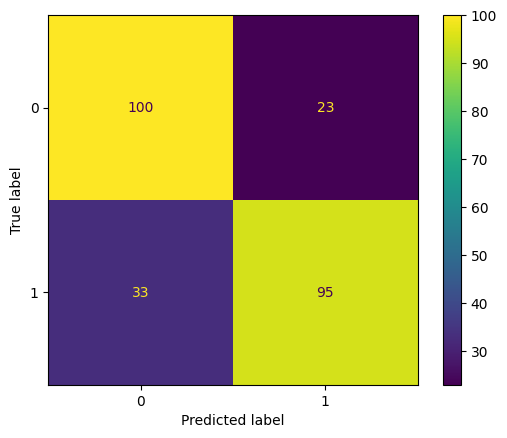

In [47]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

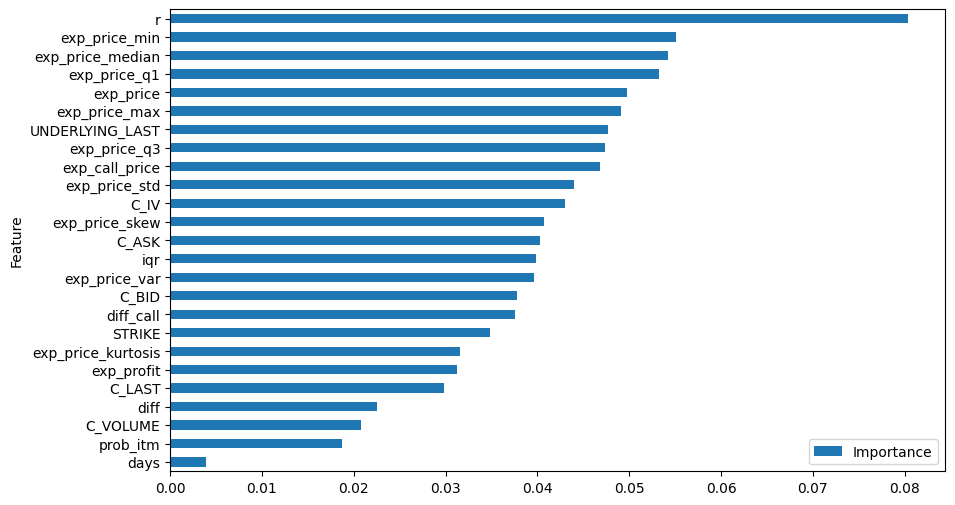

In [48]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': new_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

## Classifer with orig data + r

In [49]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [50]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [51]:
target

Date
2018-01-02    1
2018-01-03    1
2018-01-04    1
2018-01-05    1
2018-01-08    1
             ..
2022-12-23    1
2022-12-26    1
2022-12-28    1
2022-12-29    1
2022-12-30    1
Name: target, Length: 1253, dtype: int64

In [52]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [53]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [54]:
int_rate = wk_df["r"].values

In [55]:
int_rate

array([1.28, 1.29, 1.29, ..., 3.87, 3.86, 4.04])

In [56]:
orig_df = ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff_date"]].copy()

In [57]:
# Add interest rate
orig_df["r"] = int_rate

In [58]:
X_train, X_test, y_train, y_test = train_test_split(orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968)

In [59]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier())])

In [60]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 25)]
# Number of features to consider at every split
max_features = [None, 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion = ["gini", "entropy", "log_loss"]
# Create the random grid
random_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap, 
               'rf__criterion':criterion,
               }


In [61]:
n_iter = 200
verbose_level = 1
n_jobs = 4

In [62]:
# Grid search
rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = random_grid, n_iter = n_iter, cv = 5, verbose=verbose_level, random_state=1968, n_jobs = n_jobs)

In [63]:
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer',
                                              SimpleImputer(fill_value=0.0,
                                                            strategy='constant')),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=200, n_jobs=4,
                   param_distributions={'rf__bootstrap': [True, False],
                                        'rf__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'rf__max_depth': [2, 4, 6, 8, 10, 12,
                                                          14, 16, 18, 20,
                                                          None],
                                        'rf__max_features': [None, 'sqrt',
                                                             'log2'],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [10, 17, 25, 33, 41,
                                                             49, 57, 65, 73, 81,
                                                             89, 97, 105, 112,
                                                             120, 128, 136, 144,
                                                             152, 160, 168, 176,
                                                             184, 192, 200]},
                   random_state=1968, verbose=1)

In [64]:
rf_random.best_params_

{'rf__n_estimators': 160,
 'rf__min_samples_split': 2,
 'rf__min_samples_leaf': 4,
 'rf__max_features': 'log2',
 'rf__max_depth': 12,
 'rf__criterion': 'gini',
 'rf__bootstrap': False}

In [65]:
pd.DataFrame.from_dict(rf_random.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__max_depth,param_rf__criterion,param_rf__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
52,0.557001,0.015174,0.019985,0.003733,160,2,4,log2,12,gini,False,"{'rf__n_estimators': 160, 'rf__min_samples_spl...",0.756219,0.761194,0.775,0.760,0.785,0.767483,0.010824,1
131,0.390787,0.009953,0.013845,0.003760,97,5,4,log2,16,gini,False,"{'rf__n_estimators': 97, 'rf__min_samples_spli...",0.766169,0.756219,0.765,0.755,0.785,0.765478,0.010746,2
127,0.125497,0.005294,0.005730,0.002492,25,2,1,log2,14,log_loss,False,"{'rf__n_estimators': 25, 'rf__min_samples_spli...",0.766169,0.776119,0.745,0.760,0.765,0.762458,0.010175,3
31,0.759251,0.026547,0.026408,0.002137,200,5,4,sqrt,None,gini,False,"{'rf__n_estimators': 200, 'rf__min_samples_spl...",0.766169,0.761194,0.760,0.725,0.795,0.761473,0.022265,4
100,0.166973,0.008404,0.006473,0.001880,33,5,4,sqrt,20,log_loss,False,"{'rf__n_estimators': 33, 'rf__min_samples_spli...",0.766169,0.761194,0.750,0.775,0.755,0.761473,0.008702,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.181972,0.009617,0.011392,0.001253,89,10,1,log2,2,log_loss,False,"{'rf__n_estimators': 89, 'rf__min_samples_spli...",0.557214,0.601990,0.565,0.580,0.565,0.573841,0.015894,196
74,0.225761,0.015753,0.013011,0.002475,128,10,1,sqrt,2,gini,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.542289,0.562189,0.625,0.570,0.560,0.571896,0.028057,197
15,0.267007,0.016656,0.015296,0.001097,128,2,2,sqrt,2,log_loss,False,"{'rf__n_estimators': 128, 'rf__min_samples_spl...",0.557214,0.597015,0.570,0.590,0.540,0.570846,0.020927,198
166,0.206629,0.003956,0.010260,0.001493,97,5,4,sqrt,2,entropy,True,"{'rf__n_estimators': 97, 'rf__min_samples_spli...",0.577114,0.567164,0.600,0.565,0.540,0.569856,0.019409,199


In [66]:
best_model = rf_random.best_estimator_

In [67]:
best_model.score(X_test, y_test)

0.7529880478087649

In [68]:
predictions = best_model.predict(X_test)

In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       123
           1       0.79      0.70      0.74       128

    accuracy                           0.75       251
   macro avg       0.76      0.75      0.75       251
weighted avg       0.76      0.75      0.75       251



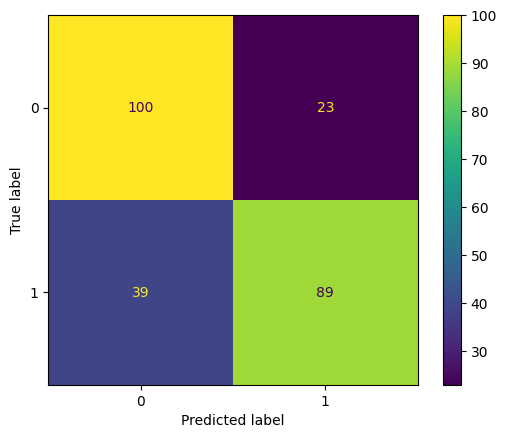

In [70]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

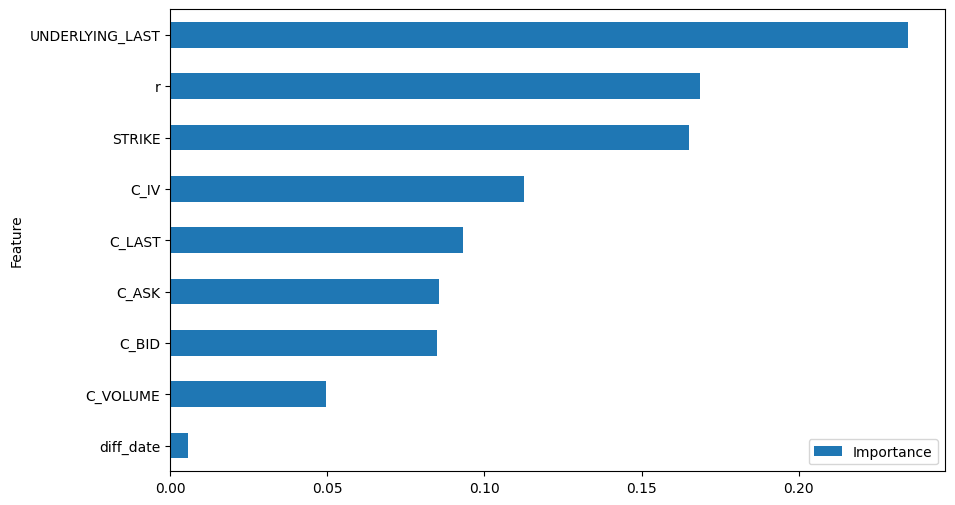

In [71]:
coefficients = best_model.named_steps["rf"].feature_importances_

feature_importance = pd.DataFrame({'Feature': orig_df.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));